Images shape: (2656, 256, 256, 3)
[[212. 212. 217. 222. 228.]
 [212. 212. 217. 222. 228.]
 [218. 218. 221. 221. 219.]
 [224. 224. 226. 222. 212.]
 [231. 231. 232. 224. 206.]]
Masks shape: (2656, 256, 256, 6)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


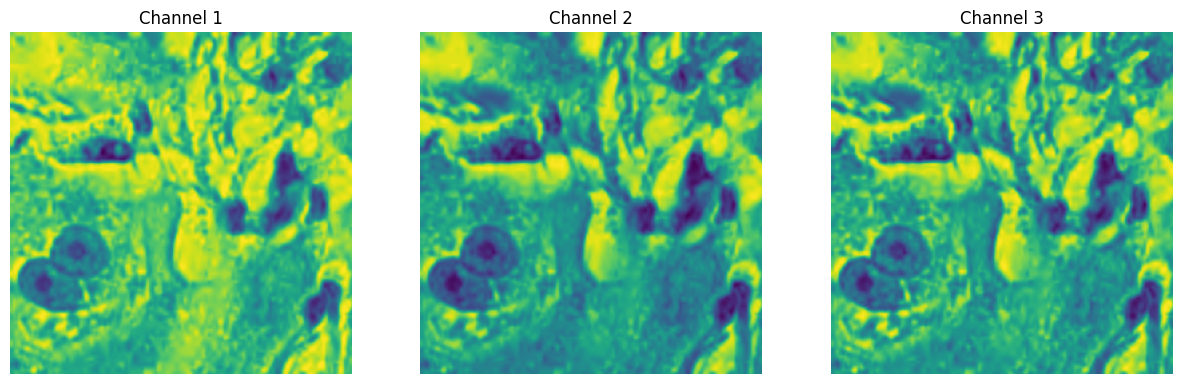

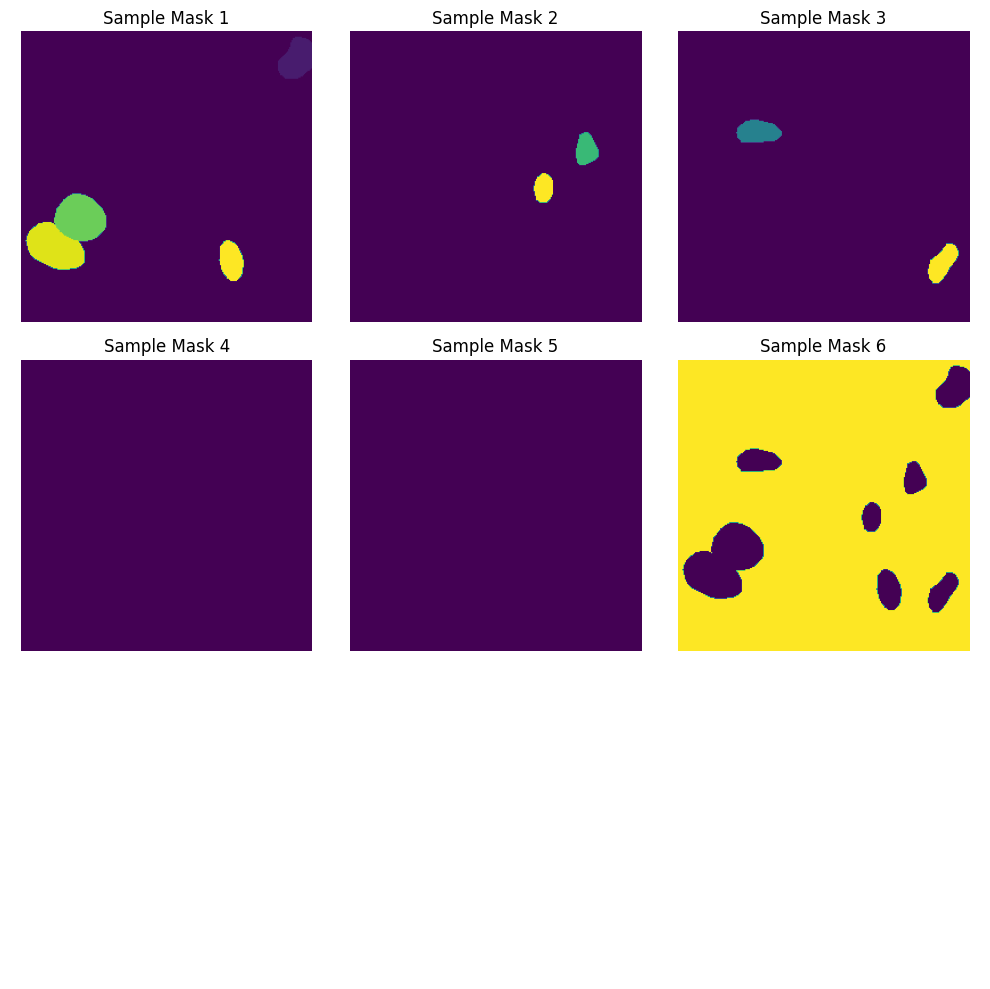

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the paths to the .npy files
image_file = '../data/raw/pannuke/Fold 1/images/fold1/images.npy'
mask_file = '../data/raw/pannuke/Fold 1/masks/fold1/masks.npy'

# Load the images and masks
images = np.load(image_file)
masks = np.load(mask_file)

# Inspect the shape of the loaded arrays
print(f"Images shape: {images.shape}")
print(images[0, :5, :5, 0]) 
print(f"Masks shape: {masks.shape}")
print(masks[0, :5, :5, 0]) 


# Display a sample image and its corresponding mask
sample_index = 0
sample_image = images[sample_index]
sample_mask = masks[sample_index]

# Display each channel of the image separately
num_channels = sample_image.shape[-1]
num_channels_masks = sample_mask.shape[-1]

plt.figure(figsize=(15, 5))

for i in range(num_channels):
    plt.subplot(1, num_channels, i + 1)
    plt.imshow(sample_image[:, :, i])
    plt.title(f'Channel {i + 1}')
    plt.axis('off')

plt.show()

rows = 3
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

# Loop through each channel and plot
for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    if i < num_channels_masks:
        ax.imshow(sample_mask[:, :, i])
        ax.set_title(f'Sample Mask {i + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [3]:
# Load the types.npy file
masks_path = '../data/raw/pannuke/Fold 1/masks/fold1/masks.npy'  # Replace with the actual path to your types.npy file
masks = np.load(masks_path)

# Inspect the shape and contents of the types array
print(f"Types shape: {masks.shape}")
print(f"Unique types: {np.unique(masks[0][:,:,0])}")

Types shape: (2656, 256, 256, 6)
Unique types: [ 0.  3. 31. 38. 40.]


In [4]:
# Load the types.npy file
types_path = '../data/raw/pannuke/Fold 1/images/fold1/types.npy'  # Replace with the actual path to your types.npy file
types = np.load(types_path)

# Inspect the shape and contents of the types array
print(f"Types shape: {types.shape}")
print(f"Unique types: {np.unique(types)}")

Types shape: (2656,)
Unique types: ['Adrenal_gland' 'Bile-duct' 'Bladder' 'Breast' 'Cervix' 'Colon'
 'Esophagus' 'HeadNeck' 'Kidney' 'Liver' 'Lung' 'Ovarian' 'Pancreatic'
 'Prostate' 'Skin' 'Stomach' 'Testis' 'Thyroid' 'Uterus']


In [5]:
sample_mask[:, :, 5]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

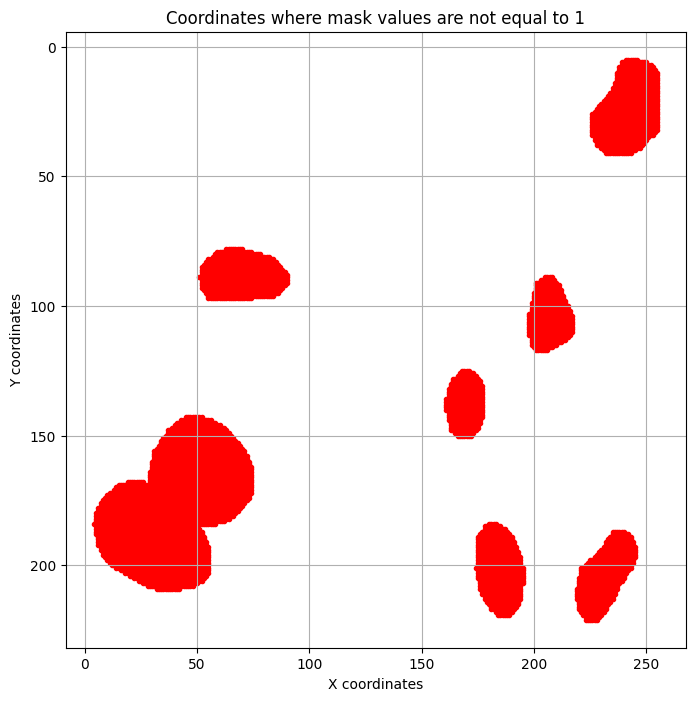

In [6]:
# Assuming sample_mask[:, :, 5] is your mask where 1 indicates presence and 0 indicates absence
mask = sample_mask[:, :, 5]

# Find coordinates where mask values are not equal to 1
non_one_indices = np.where(mask != 1)
y_coords, x_coords = non_one_indices  # Get the y and x coordinates

# Plotting the coordinates
plt.figure(figsize=(8, 8))
plt.scatter(x_coords, y_coords, marker='.', color='red')
plt.title('Coordinates where mask values are not equal to 1')
plt.xlabel('X coordinates')
plt.ylabel('Y coordinates')
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates (optional)
plt.grid(True)
plt.show()

In [8]:
# Take only the first 1000 samples
images = images[:500]
masks = masks[:500]

# Assuming `single_masks` refers to the last mask in the masks array
single_masks = masks[:, :, :, -1]  # Taking the last mask (4th dimension)

# Reshape single_masks to match the input format for U-Net
single_masks = np.expand_dims(single_masks, axis=-1)

# Split the dataset into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(images, single_masks, test_size=0.2, random_state=42)

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=conv10)

    return model


2024-07-22 20:18:56.162685: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model = unet_model()

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_7[0][0], 

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(X_train, Y_train, batch_size=16, epochs=5, validation_data=(X_val, Y_val))

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 610s 24s/step - accuracy: 0.6353 - loss: 3.6420 - val_accuracy: 0.8196 - val_loss: 0.3914
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 678s 27s/step - accuracy: 0.8303 - loss: 0.3388 - val_accuracy: 0.8807 - val_loss: 0.3096
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 675s 27s/step - accuracy: 0.8970 - loss: 0.2406 - val_accuracy: 0.9013 - val_loss: 0.2222
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 908s 37s/step - accuracy: 0.9117 - loss: 0.2051 - val_accuracy: 0.9038 - val_loss: 0.2165
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 747s 30s/step - accuracy: 0.9051 - loss: 0.2142 - val_accuracy: 0.9024 - val_loss: 0.2181


In [13]:
model.save('../data/processed/pannuke/all_500_5e.h5')

(20, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


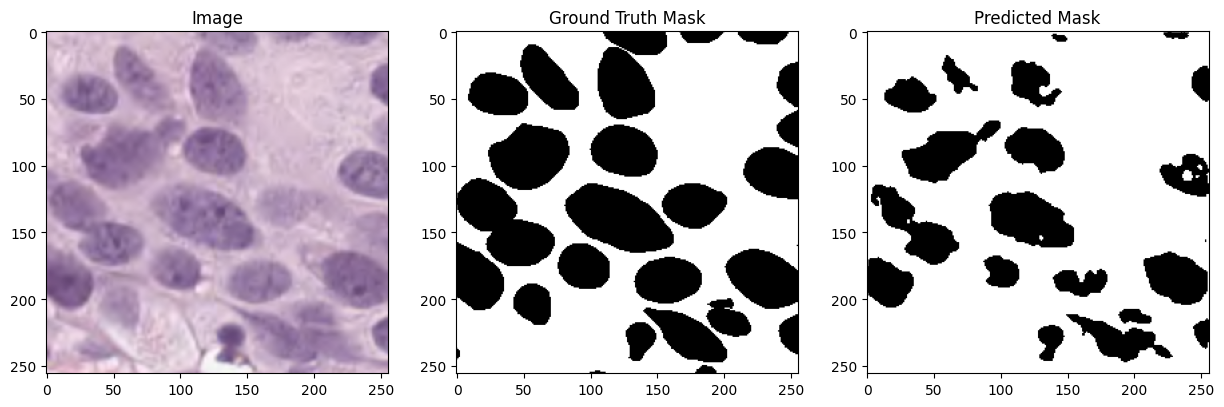

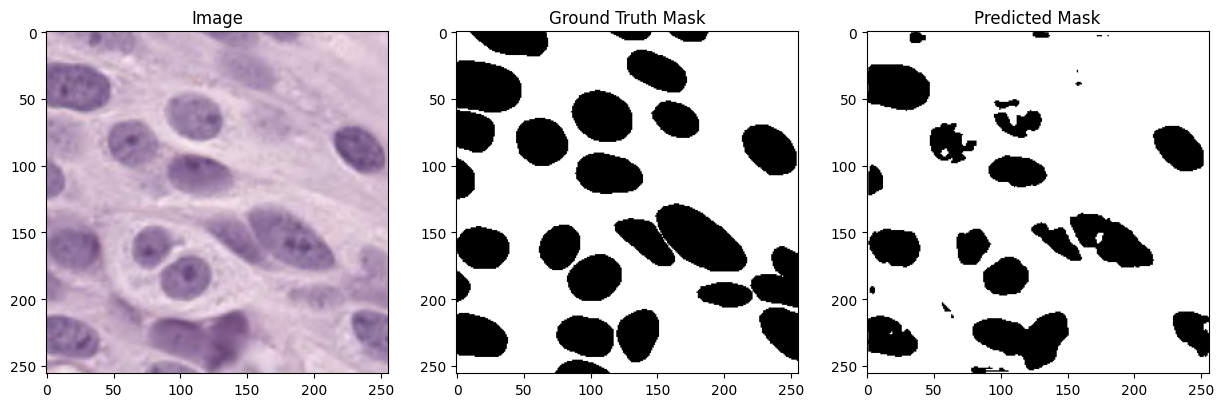

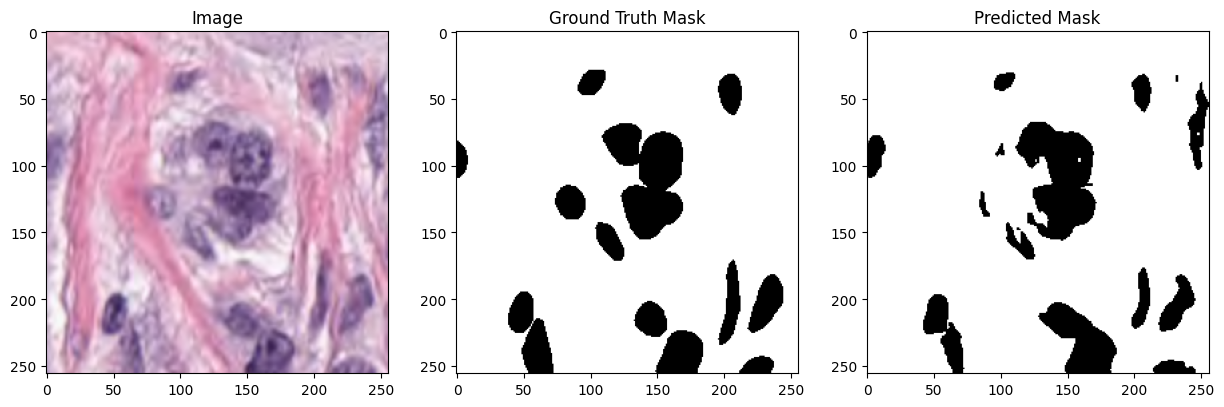

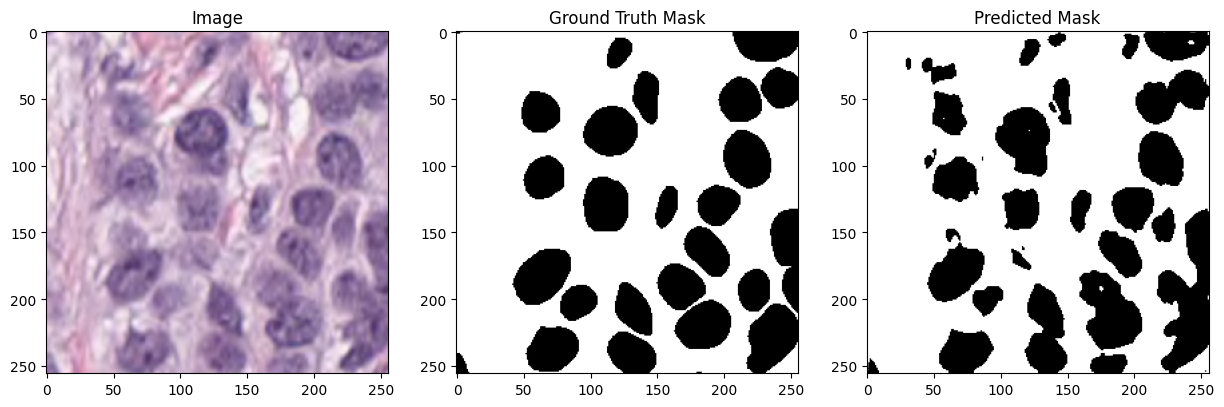

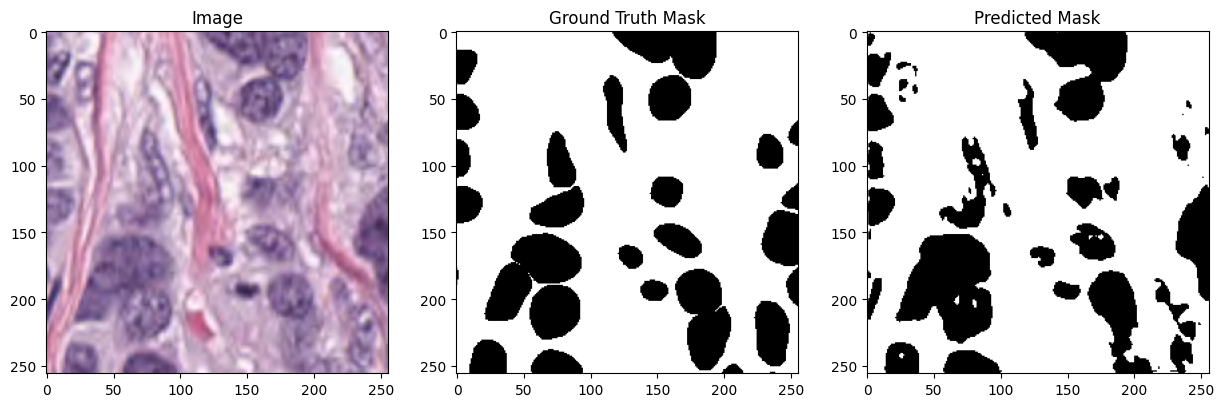

In [20]:
import numpy as np
import matplotlib.pyplot as plt

images = np.load(image_file)
masks = np.load(mask_file)
X_test = images[510:530]
masks = np.load(mask_file)
masks = masks[:, :, :, -1]
Y_test = masks[510:530]

# TODO Normalize? i did not do it yet
# X_test = X_test / 255.0

Y_pred = model.predict(X_test)

# Reshape predictions to match ground truth
Y_pred_thresholded = (Y_pred > 0.5).astype(np.uint8)

# Remove the last channel dimension
Y_pred_thresholded = np.squeeze(Y_pred_thresholded, axis=-1)


def plot_sample(image, true_mask, pred_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image.astype(int))
    axes[0].set_title('Image')
    axes[1].imshow(true_mask.squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[2].imshow(pred_mask.squeeze(), cmap='gray')
    axes[2].set_title('Predicted Mask')
    plt.show()

for i in range(5):
    plot_sample(X_test[i], Y_test[i], Y_pred_thresholded[i])


In [21]:

import sys
sys.path.append('../utils')
import os
import image_cropp_utils

from image_cropp_utils import read_image

dir_base = '/Users/lollijagladiseva/Desktop/cellseg_visium_hd/data/processed/'
filename = 'p5_cropped_image_overlap_comparison.btf'
img = read_image(dir_base + filename)

In [23]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

def extract_patches(image, patch_size=(256, 256), overlap=0.5):
    patches = []
    stride = int(patch_size[0] * (1 - overlap))
    for y in range(0, image.shape[0] - patch_size[0] + 1, stride):
        for x in range(0, image.shape[1] - patch_size[1] + 1, stride):
            patch = image[y:y + patch_size[0], x:x + patch_size[1]]
            patches.append((patch, (x, y)))
    return patches

def plot_patch_vs_mask(original_patch, predicted_mask_patch):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_patch)
    axes[0].set_title('Original Patch')
    axes[0].axis('off')

    axes[1].imshow(predicted_mask_patch.squeeze(), cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')

    plt.show()

large_image = img

patch_size = (256, 256)
overlap = 0.5
patches = extract_patches(large_image, patch_size=patch_size, overlap=overlap)

model = tf.keras.models.load_model('/Users/lollijagladiseva/Desktop/cellseg_visium_hd/data/processed/pannuke/all_500_5e.h5')
predictions = []
predictions_thresholded = []

for patch, position in patches:
    patch = patch[np.newaxis, ...]
    pred = model.predict(patch.astype(int))
    predictions.append((pred.squeeze(), position)) # TODO not needed, keeping just to see actual prdictions
    pred = (pred > 0.5).astype(np.uint8)  # threshold prediction
    predictions_thresholded.append((pred.squeeze(), position))  # remove batch dimension


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

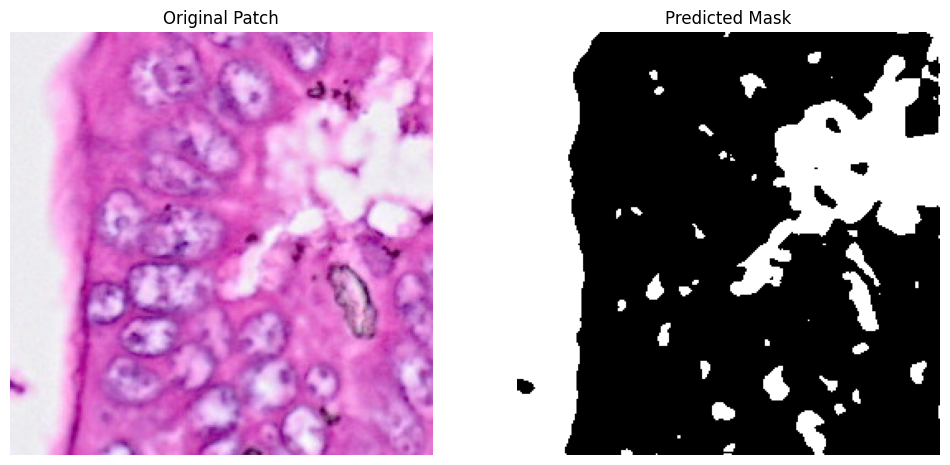

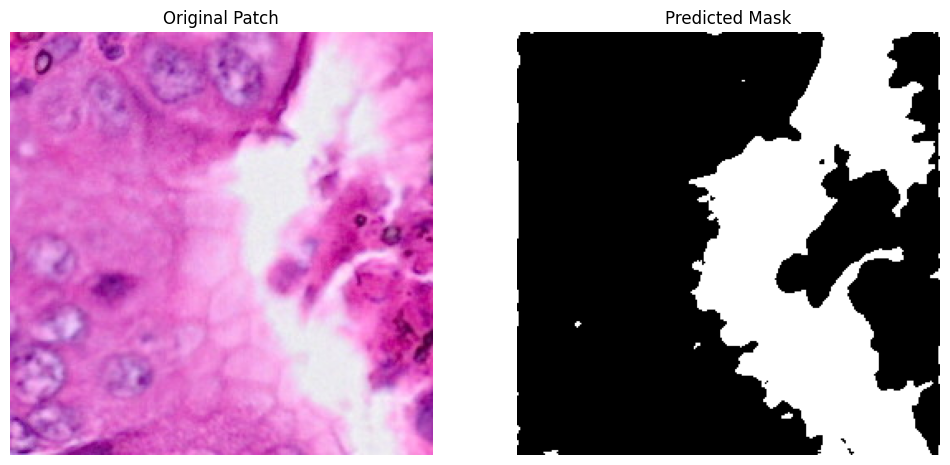

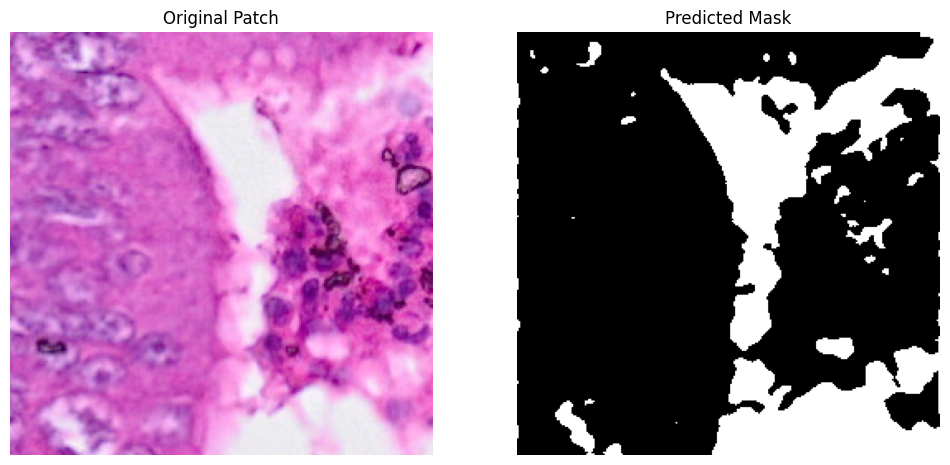

In [24]:
# 3 random patches
random_indices = random.sample(range(len(patches)), 3)
for i in random_indices:
    patch, _ = patches[i]
    pred, _ = predictions_thresholded[i]
    
    plot_patch_vs_mask(patch, pred)